<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   location        13200 non-null  object 
 1   size            13200 non-null  object 
 2   total_sqft      13200 non-null  float64
 3   bath            13200 non-null  float64
 4   price           13200 non-null  float64
 5   bhk             13200 non-null  int64  
 6   price_per_sqft  13200 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 722.0+ KB
         total_sqft          bath         price           bhk  price_per_sqft
count  13200.000000  13200.000000  13200.000000  13200.000000    1.320000e+04
mean    1555.302783      2.691136    112.276178      2.800833    7.920337e+03
std     1237.323445      1.338915    149.175995      1.292843    1.067272e+05
min        1.000000      1.000000      8.000000      1.000000    2.670000e+02
25%     1100.000000      2.000000

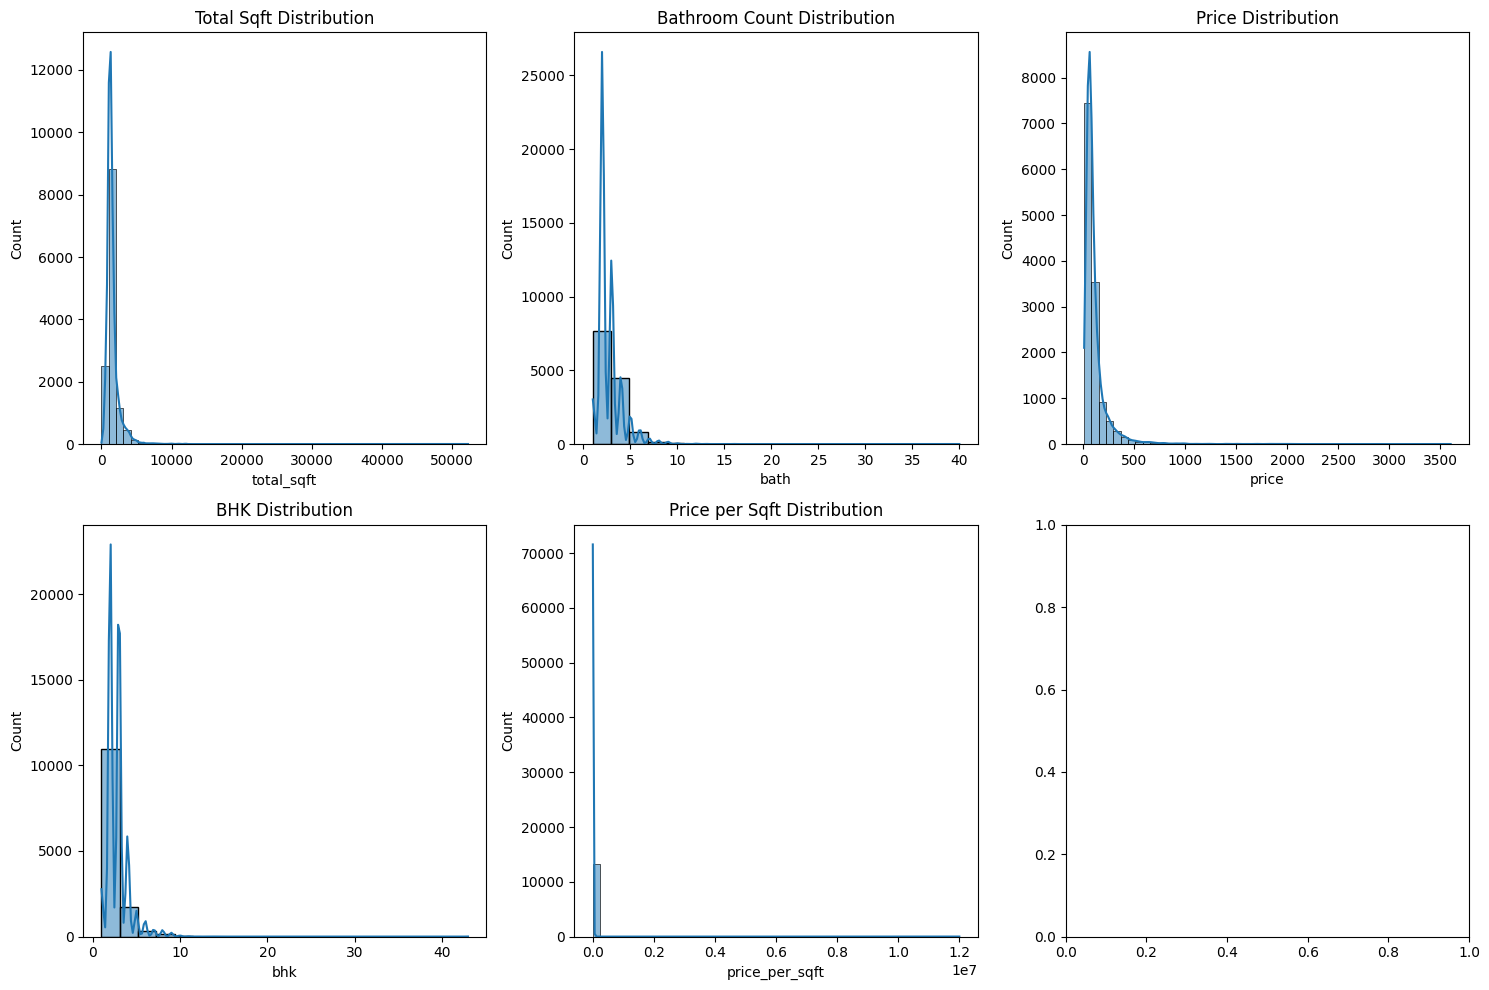

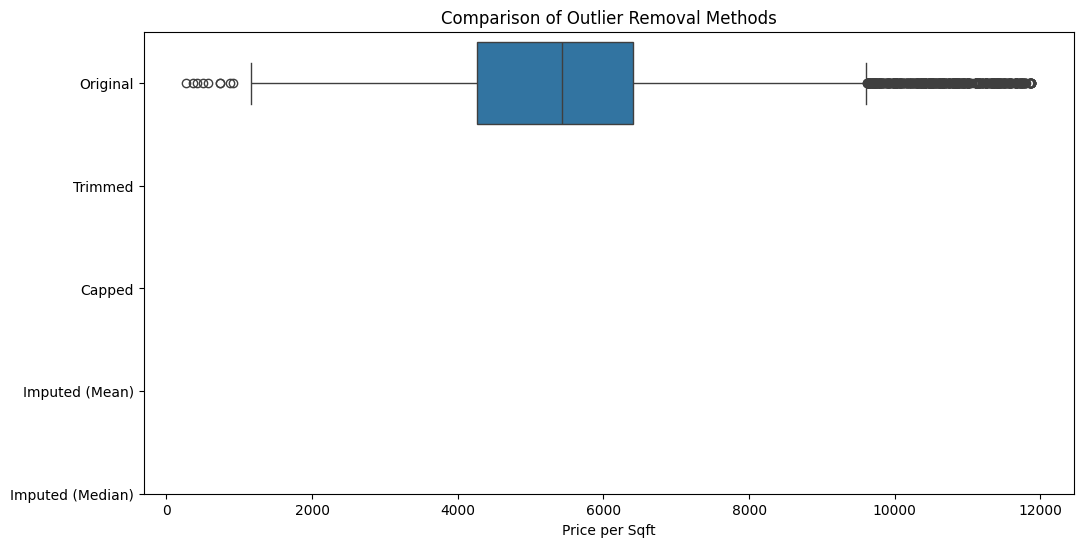

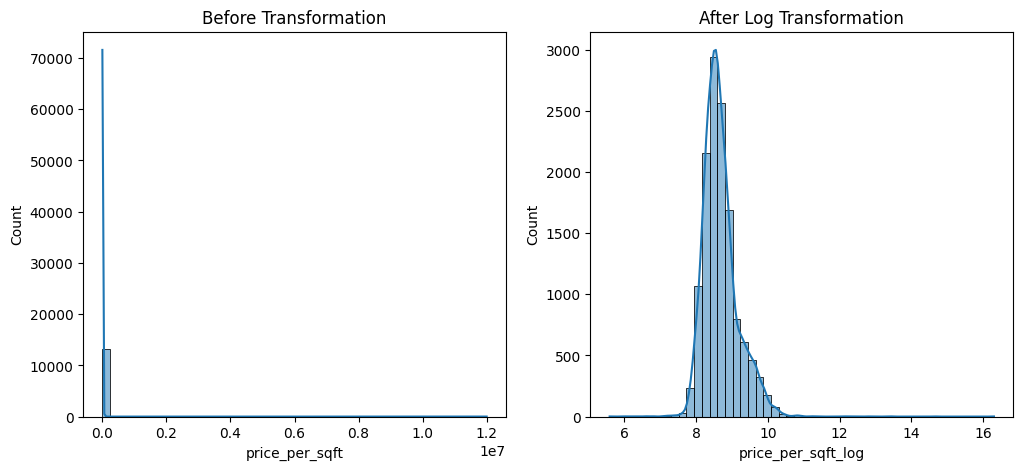

Skewness Before: 108.26875024325159, Kurtosis Before: 12090.633538860382
Skewness After: 1.4003259019533636, Kurtosis After: 9.203000543610957


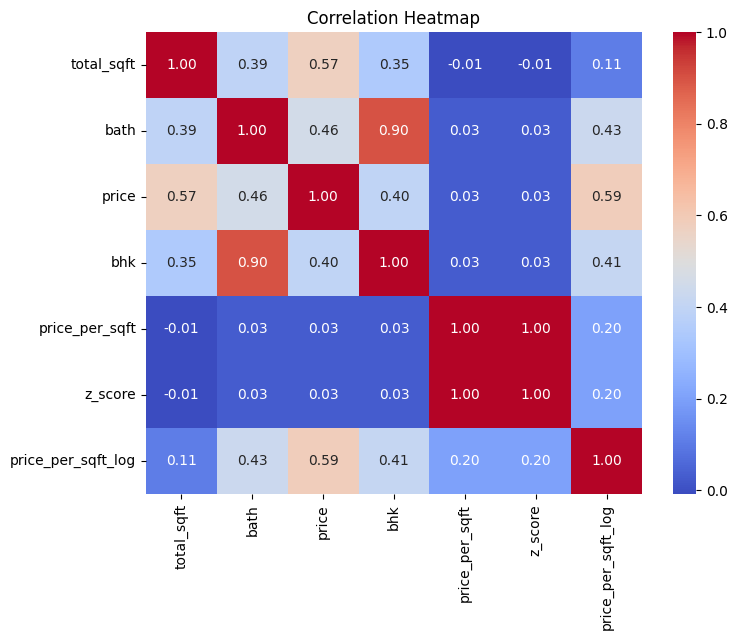

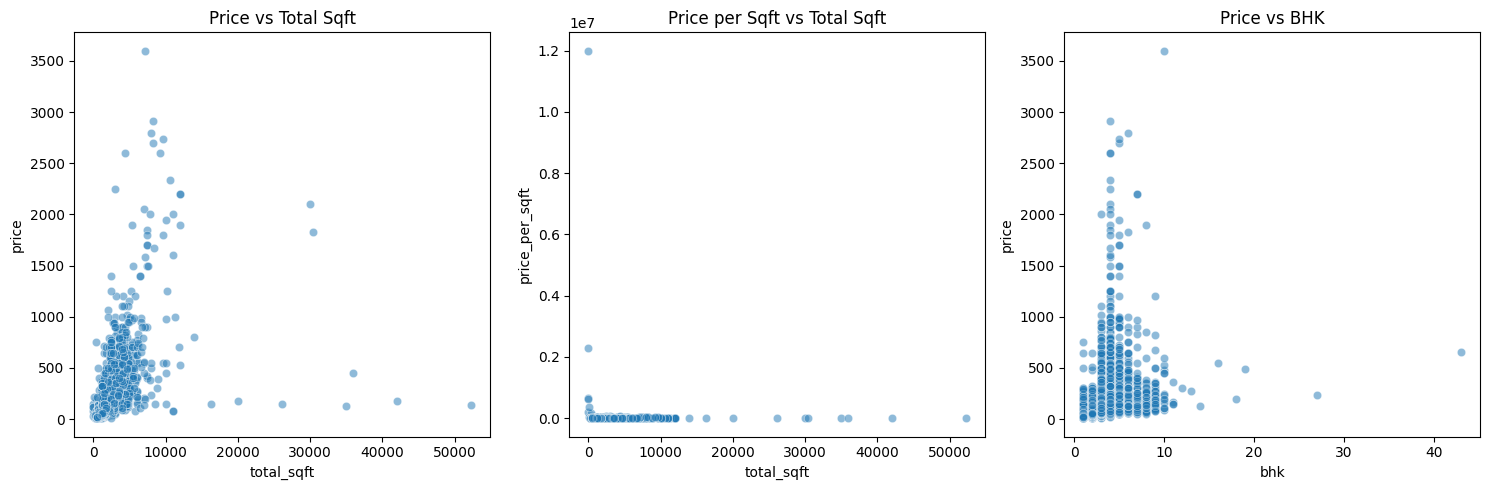

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, skew, kurtosis

# Load Dataset

df = pd.read_csv('/content/house_price.csv')

# Display basic info
df.info()
print(df.describe())

# EDA - Plot Distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.histplot(df['total_sqft'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Total Sqft Distribution')

sns.histplot(df['bath'], bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Bathroom Count Distribution')

sns.histplot(df['price'], bins=50, kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Price Distribution')

sns.histplot(df['bhk'], bins=20, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('BHK Distribution')

sns.histplot(df['price_per_sqft'], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Price per Sqft Distribution')

plt.tight_layout()
plt.show()

# Outlier Detection
# 1. Mean & Standard Deviation
mean = df['price_per_sqft'].mean()
std = df['price_per_sqft'].std()
lower_bound_std, upper_bound_std = mean - 3 * std, mean + 3 * std

# 2. Percentile Method
lower_percentile = df['price_per_sqft'].quantile(0.01)
upper_percentile = df['price_per_sqft'].quantile(0.99)

# 3. IQR Method
Q1 = df['price_per_sqft'].quantile(0.25)
Q3 = df['price_per_sqft'].quantile(0.75)
IQR = Q3 - Q1
lower_bound_iqr, upper_bound_iqr = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

# 4. Z-Score Method
df['z_score'] = zscore(df['price_per_sqft'])
z_threshold = 3

# Removing Outliers
# Trimming (Percentile)
df_trimmed = df[(df['price_per_sqft'] >= lower_percentile) & (df['price_per_sqft'] <= upper_percentile)]

# Capping (IQR)
df_capped = df.copy()
df_capped['price_per_sqft'] = df_capped['price_per_sqft'].clip(lower_bound_iqr, upper_bound_iqr)

# Imputation (Mean)
df_imputed_mean = df.copy()
df_imputed_mean['price_per_sqft'] = np.where(
    (df['price_per_sqft'] < lower_bound_iqr) | (df['price_per_sqft'] > upper_bound_iqr),
    df['price_per_sqft'].mean(),
    df['price_per_sqft']
)

# Imputation (Median)
df_imputed_median = df.copy()
df_imputed_median['price_per_sqft'] = np.where(
    (df['price_per_sqft'] < lower_bound_iqr) | (df['price_per_sqft'] > upper_bound_iqr),
    df['price_per_sqft'].median(),
    df['price_per_sqft']
)

#3 Box Plot Comparison
plt.figure(figsize=(12, 6))
sns.boxplot(data=[df['price_per_sqft'], df_trimmed['price_per_sqft'], df_capped['price_per_sqft'],
                  df_imputed_mean['price_per_sqft'], df_imputed_median['price_per_sqft']], orient='h')
plt.yticks([0, 1, 2, 3, 4], ['Original', 'Trimmed', 'Capped', 'Imputed (Mean)', 'Imputed (Median)'])
plt.xlabel("Price per Sqft")
plt.title("Comparison of Outlier Removal Methods")
plt.show()

#4 Normality Check & Transformation
skew_before = skew(df['price_per_sqft'])
kurtosis_before = kurtosis(df['price_per_sqft'])

df['price_per_sqft_log'] = np.log1p(df['price_per_sqft'])

skew_after = skew(df['price_per_sqft_log'])
kurtosis_after = kurtosis(df['price_per_sqft_log'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['price_per_sqft'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Before Transformation')

sns.histplot(df['price_per_sqft_log'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('After Log Transformation')

plt.show()
print(f"Skewness Before: {skew_before}, Kurtosis Before: {kurtosis_before}")
print(f"Skewness After: {skew_after}, Kurtosis After: {kurtosis_after}")

#5 Correlation Heatmap using only numerical columns
numerical_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(8, 6))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#6 Scatter Plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(x=df['total_sqft'], y=df['price'], alpha=0.5, ax=axes[0])
axes[0].set_title('Price vs Total Sqft')

sns.scatterplot(x=df['total_sqft'], y=df['price_per_sqft'], alpha=0.5, ax=axes[1])
axes[1].set_title('Price per Sqft vs Total Sqft')

sns.scatterplot(x=df['bhk'], y=df['price'], alpha=0.5, ax=axes[2])
axes[2].set_title('Price vs BHK')

plt.tight_layout()
plt.show()



